In [1]:
cd ..

/Users/flamholz/Documents/workspace/ccm_evolution


In [2]:
mkdir -p figures/fig2

In [3]:
import numpy as np
import pandas as pd
import re
import seaborn as sns

from matplotlib import pyplot as plt

In [4]:
# Genes we want to plot - commenting out those that are not as interesting.
# TODO: make a configurable "to_plot" key
genes_of_interest = {
#    'HNEAP_RS07320': dict(name='Crp/Fnr', kind='regulation'),
    'HNEAP_RS01030': dict(name='DAB2B', kind='transport'),
    'HNEAP_RS01035': dict(name='DAB2A', kind='transport'), 
    'HNEAP_RS04585': dict(name='DAB1B', kind='transport'),
    'HNEAP_RS04595': dict(name='DAB1A', kind='transport'),
#    'HNEAP_RS01040': dict(name='LysR DAB2', kind='regulation'),
    'HNEAP_RS04645': dict(name='csosCA', kind='CA'),
    'HNEAP_RS04565': dict(name='csos1D', kind='carboxysome'),
    'HNEAP_RS04655': dict(name='cbbS', kind='rubisco'),
#    'HNEAP_RS04615': dict(name='acRAF', kind='chaperone'),
    'HNEAP_RS04625': dict(name='csos1A', kind='carboxysome'),
    'HNEAP_RS04660': dict(name='cbbL', kind='rubisco'),
#    'HNEAP_RS05490': dict(name='LysR', kind='regulation'),
    'HNEAP_RS04640': dict(name='csos4A', kind='carboxysome'),
    'HNEAP_RS04635': dict(name='csos4B', kind='carboxysome'),
    'HNEAP_RS04650': dict(name='csos2', kind='carboxysome'),
    'HNEAP_RS04630': dict(name='csos1C', kind='carboxysome'), 
}

barseq_df = pd.read_csv('data/Hnea/barseq/fit_logratios_all.csv')

In [5]:
mask = barseq_df.locus_id.isin(genes_of_interest.keys())
subset_df = barseq_df[mask].copy()

In [6]:
numeric_cols = (subset_df.dtypes == np.float64)
long_subset_df = subset_df.melt('locus_id', value_vars=subset_df.columns[numeric_cols])

gene_tags = [genes_of_interest.get(row.locus_id)['kind'] for _, row in long_subset_df.iterrows()]
conds = [re.sub('CO2.\d+', 'CO2', row.variable) for _, row in long_subset_df.iterrows()]
long_subset_df['gene_tag'] = gene_tags
long_subset_df['cond'] = conds
long_subset_df.head()

,locus_id,variable,value,gene_tag,cond
0,HNEAP_RS01030,5% CO2,-0.009401,transport,5% CO2
1,HNEAP_RS01035,5% CO2,0.052684,transport,5% CO2
2,HNEAP_RS04565,5% CO2,0.015781,carboxysome,5% CO2
3,HNEAP_RS04585,5% CO2,-0.432006,transport,5% CO2
4,HNEAP_RS04595,5% CO2,-0.300871,transport,5% CO2


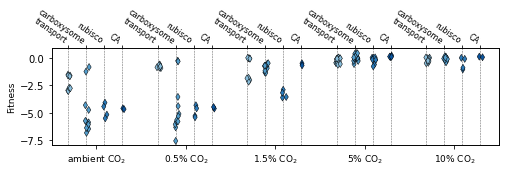

In [7]:
plt.figure(figsize=(7,2.5))
xorder = 'ambient CO2,0.5% CO2,1.5% CO2,5% CO2,10% CO2'.split(',')
hue_order = 'transport,carboxysome,rubisco,CA'.split(',')
pal = sns.color_palette('Blues')
greys = sns.color_palette('Greys')

sns.stripplot(data=long_subset_df, x='cond', y='value', hue='gene_tag', dodge=0.25,
              order=xorder, hue_order=hue_order,
              marker='d', edgecolor='k', linewidth=0.5, palette=pal[-4:])
plt.legend().set_visible(False)

xticks = 'ambient CO$_2$,0.5% CO$_2$,1.5% CO$_2$,5% CO$_2$,10% CO$_2$'.split(',')
plt.xticks(np.arange(5), xticks, rotation=0, ha='center', fontsize=9)
plt.ylabel('Fitness', fontsize=9)
plt.xlabel('')

xticks = np.arange(0, 0.8, 0.2) - 0.3125
xticks = np.hstack([xticks, xticks+1, xticks+2, xticks+3, xticks+4])
xtick_str = hue_order*5
for xpos in xticks:
    plt.axvline(xpos, ls='--', lw=0.5, zorder=-1, color=greys[-2])
    
ax = plt.gca()
axT = ax.twiny()
plt.sca(axT)

plt.xticks(xticks, xtick_str, ha='right', rotation=-35, fontsize=8)
plt.tick_params(pad=0)
plt.xlim(ax.get_xlim())

plt.tight_layout()
plt.savefig('figures/fig2/fig2.png', dpi=600, facecolor='w')
plt.show()